In [1]:
from oddt.scoring.descriptors import oddt_vina_descriptor
from oddt.toolkits import rdk, ob

import json
import numpy as np
from joblib import delayed, Parallel
from functools import partial
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

from matplotlib import pyplot as plt
import json
import pandas as pd

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

PDBBIND_DIR = '/home/fergus/pdbbind/v2019'

In [2]:
T = 298
R = 0.001987# kcal/mol
def dg_to_pk(dg):
    pk = -np.log10(np.exp(dg/(R*T)))
    return pk

def dg_to_pk1(dg):
    pk = -dg / (2.3003 * R * T)
    return pk

In [3]:
with open('../data/pdbbind_training_set.txt') as f:
    train_pdbs = [l.strip() for l in f]
    
with open('../data/pdbbind_test_set.txt') as f:
    test_pdbs = [l.strip() for l in f]
    
pdbs = train_pdbs + test_pdbs

In [6]:
@delayed
def build(pdb):
    vina = oddt_vina_descriptor()
    protein = next(ob.readfile('pdb', f'{PDBBIND_DIR}/{pdb}/{pdb}_protein.pdb'))
    protein.protein = True
    # crystal
    ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    features_c = vina.build(ligand, protein)[0]
    # docked        
    ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf'))
    features_d = vina.build(ligand, protein)[0]
    # minimized
    ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_minimized.sdf'))
    features_m = vina.build(ligand, protein)[0]
    return (features_c, features_d, features_m)

In [8]:
with Parallel(n_jobs=8, verbose=10) as parallel:
    results = parallel(build(pdb) for pdb in pdbs)
vina_crystal = {pdb: result[0][0] for pdb, result in zip(pdbs, results)}
vina_docked = {pdb: result[1][0] for pdb, result in zip(pdbs, results)}
vina_minimized = {pdb: result[2][0] for pdb, result in zip(pdbs, results)}

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   32.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   36.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   40.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   44.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   50.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   58.2s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(

In [9]:
vina_crystal_pk = pd.Series({pdb: dg_to_pk(vina_crystal[pdb]) for pdb in vina_crystal})
vina_docked_pk = pd.Series({pdb: dg_to_pk(vina_docked[pdb]) for pdb in vina_crystal})
vina_minimized_pk = pd.Series({pdb: dg_to_pk(vina_minimized[pdb]) for pdb in vina_crystal})

vina_crystal_pk.to_csv('../results/vina_crystal_predicted_pk.csv')
vina_docked_pk.to_csv('../results/vina_docked_predicted_pk.csv')
vina_minimized_pk.to_csv('../results/vina_minimized_predicted_pk.csv')

(array([  8.,  45.,  85., 109., 121.,  79.,  50.,  14.,   5.,   3.]),
 array([ 1.57085614,  2.54352059,  3.51618504,  4.4888495 ,  5.46151395,
         6.4341784 ,  7.40684286,  8.37950731,  9.35217176, 10.32483622,
        11.29750067]),
 <BarContainer object of 10 artists>)

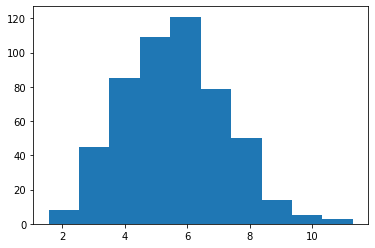

In [93]:
plt.hist(vina_docked_pk)

(array([  8.,  45.,  85., 109., 121.,  79.,  50.,  14.,   5.,   3.]),
 array([ 1.57241661,  2.5460473 ,  3.51967798,  4.49330867,  5.46693936,
         6.44057005,  7.41420073,  8.38783142,  9.36146211, 10.3350928 ,
        11.30872348]),
 <BarContainer object of 10 artists>)

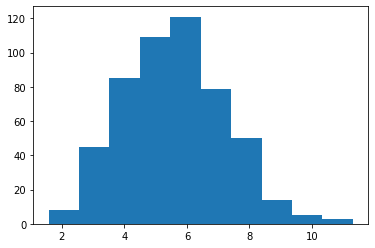

In [90]:
plt.hist(vina_docked_pk)

In [49]:
pdbbind_test_set_affinity = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [57]:
y_true = pdbbind_test_set_affinity.loc[test_pdbs]
y_pred = vina_docked_pk.loc[test_pdbs]

(0.5041569463444031, 8.255850783008433e-35)


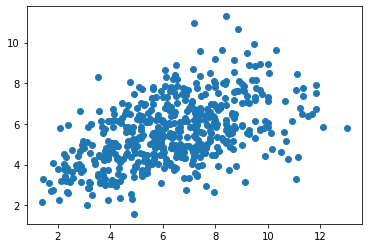

In [91]:
plt.scatter(y_true, y_pred)
print(stats.pearsonr(y_true, y_pred))

In [54]:
max(y_true)

13.0

In [85]:
bootstrap_pearsonr(y_true, y_pred)

(0.5041569463444031, 0.44002256424416675, 0.5637252639070388)

In [86]:
permutation_pearsonr(y_true, y_pred)

(0.5041569463444031, 9.999000099990002e-05)